In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 120)

1. Градиентный бустинг

1.1 Считайте таблицу с признаками из файла features.csv

In [3]:
features = pd.read_csv('C:/Users/1/Data/Dota2/features.csv', index_col='match_id')

In [4]:
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,1,11,4,3,1058,996,12,0,0,6,42,4,1085,986,12,0,0,4,21,5,2052,1536,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,0,5,39,5,1960,1384,16,0,0,8,88,3,640,566,1,0,1,5,79,3,720,1350,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,0,9,22,5,2305,2028,19,1,1,10,66,3,1024,959,19,0,1,10,86,3,755,620,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,0,6,96,5,1878,1174,17,0,0,6,48,3,732,1468,22,0,0,10,15,4,1681,1051,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,0,8,26,3,704,586,1,0,2,9,69,3,1169,1665,20,1,0,7,22,3,1055,638,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


In [5]:
X_train = features.iloc[:, :102] # обучающая выборка

1.2 Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений.

In [6]:
X_count = X_train.count() 
X_count[X_count != features.shape[0]]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

Пропуски значений в основном имеют признаки, связанные со временем наступления игрового события. Так, признак first_blood_time принимает значение NaN, если в течении 5 минут игры первое убийство героя не произошло. Соответственно не определены игроки, пролившие первую кровь (first_blood_player1, first_blood_player2), а также их команда (first_blood_team). Признак второго игрока, причастного к первой крови (first_blood_player2), отсутствует и в том случае, когда убийство совершено одним игроком самостоятельно.
По этой же причине не определены признаки, обозначающие время покупки игровых предметов (bottle, courier, flying_courier), и время установки первого "наблюдателя" (first_ward_time) - соответствующее событие просто не произошло.

1.3 Замените пропуски на нули с помощью функции fillna().

In [7]:
X_train.fillna(0, inplace = True)

1.4 Какой столбец содержит целевую переменную? Запишите его название.

In [8]:
Y_train = features['radiant_win']

Целевую переменную в данной задаче содержит столбец - radiant_win

1.5 Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True)

In [9]:
kf = KFold(n_splits = 5, 
           shuffle = True,
           random_state = 241)

Оцените качество градиентного бустинга с помощью кросс-валидации

In [10]:
grid = {'n_estimators': [5, 10, 15, 20, 25, 30]}

model = GradientBoostingClassifier(learning_rate = 0.1, 
                                   random_state = 241, 
                                   max_depth = 3)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                     

In [11]:
GB_score = gs.cv_results_['mean_test_score'] # усредненные оценки качества на кросс-валидации
GB_time = gs.cv_results_['mean_fit_time'] # усредненное время настройки алгоритма

In [12]:
# вывод результатов подбора параметров
def results(grid, parameter, score, time):
    for i in range(len(grid)):
        print(parameter, grid[i])
        print('Среднее качество: ', score[i])
        print('Среднее время обучения: ', time[i])

In [13]:
results(grid['n_estimators'], 'Количество деревьев: ',  GB_score, GB_time)

Количество деревьев:  5
Среднее качество:  0.6357376430919737
Среднее время обучения:  6.256388425827026
Количество деревьев:  10
Среднее качество:  0.6643877206345741
Среднее время обучения:  11.579198122024536
Количество деревьев:  15
Среднее качество:  0.6757420237293614
Среднее время обучения:  16.908590173721315
Количество деревьев:  20
Среднее качество:  0.6828535735340823
Среднее время обучения:  22.323270511627197
Количество деревьев:  25
Среднее качество:  0.6868481585275606
Среднее время обучения:  28.170998573303223
Количество деревьев:  30
Среднее качество:  0.6894962060591201
Среднее время обучения:  33.07759871482849


Кросс-валидация для градиентного бустинга с 30 деревьями длилась 33 секунды. AUC-ROC достиг значения 0.689.

In [14]:
# визуализация роста качества и количества затраченного на обучение времени
def Visualisation(score, time, limit = 0.05):
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                   ncols=2, 
                                   figsize=(12, 6))
    ax1.plot(score, 'g', linewidth=2)
    ax1.legend(['score'])
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('AUC-ROC')
    ax1.set_ylim([min(score) - limit, max(score) + limit])
    ax2.plot(time, 'r', linewidth=2)
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('seconds')
    ax2.legend(['time'])
    plt.show()   

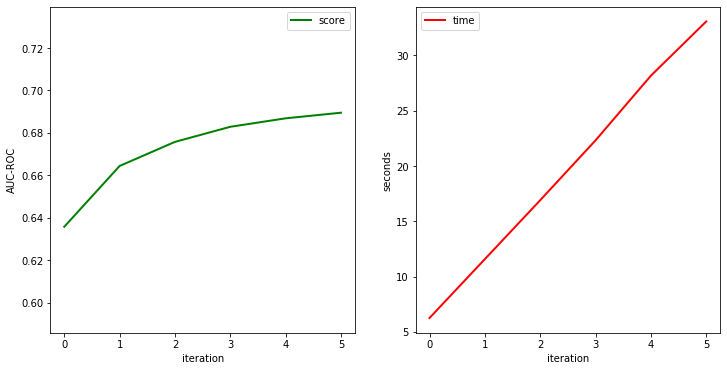

In [15]:
Visualisation(GB_score, GB_time)

Время настройки при увеличении количества деревьев растет линейно. Рост AUC-ROC на 30 деревьях замедляется, и с увеличением количества деревьев показатель метрики изменяется не существенно.

In [16]:
# градиентный бустинг из 100 деревьев
grid = {'n_estimators': [100]}

model = GradientBoostingClassifier(learning_rate = 0.1, 
                                   random_state = 241)
gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                     

In [17]:
GB_score = gs.cv_results_['mean_test_score']
GB_time = gs.cv_results_['mean_fit_time']
results(grid['n_estimators'], 'Количество деревьев: ', GB_score, GB_time)

Количество деревьев:  100
Среднее качество:  0.7063262181631453
Среднее время обучения:  111.4295419216156


На градиентном бустинге из 100 деревьев AUC-ROC = 0.706. То есть качество классификации увеличилось всего на 0.017 (при среднем времени кросс-валидации: 1 минута 51 секунда).

Один из способов повлиять на время настройки алгоритма - изменение глубины деревьев.

In [18]:
grid = {'max_depth': [1, 2, 3, 4, 5, 6]}

model = GradientBoostingClassifier(n_estimators = 30, 
                                   learning_rate = 0.1, 
                                   random_state = 241)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=30,
                      

In [19]:
GB_score = gs.cv_results_['mean_test_score']
GB_time = gs.cv_results_['mean_fit_time']
results(grid['max_depth'], 'Глубина деревьев: ', GB_score, GB_time)

Глубина деревьев:  1
Среднее качество:  0.6667026232830106
Среднее время обучения:  11.29419903755188
Глубина деревьев:  2
Среднее качество:  0.6830692110503606
Среднее время обучения:  22.261598443984987
Глубина деревьев:  3
Среднее качество:  0.6894962060591201
Среднее время обучения:  33.16878733634949
Глубина деревьев:  4
Среднее качество:  0.6945300816172659
Среднее время обучения:  44.802600622177124
Глубина деревьев:  5
Среднее качество:  0.6984783010690425
Среднее время обучения:  57.3181812286377
Глубина деревьев:  6
Среднее качество:  0.7011545262769703
Среднее время обучения:  68.9469895362854


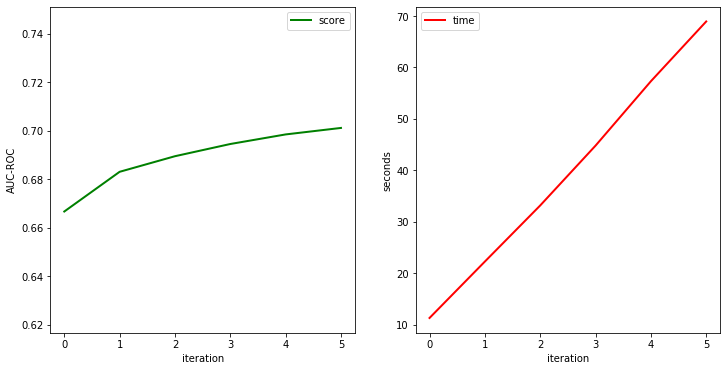

In [20]:
Visualisation(GB_score, GB_time)

Увеличение глубины деревьев не даёт ощутимого прироста качества. 30 деревьев с глубиной 6 показывают качество 0.701. А вот время настройки существенно увеличивается - 1 минута 8 секунд.
Уменьшение глубины деревьев также не сильно влияет на качество, но сокращает длительность кросс-валидации. Обучение 30 деревьев с глубиной 2 заняло в среднем 22 секунды. Достигнутое качество 0.683

Другим способом сократить время обучения является обучение алгоритма на части исходной выборки.

In [21]:
fractions = [1, 0.8, 0.6, 0.4, 0.2] # размеры долей исходной выборки
GB_score_cut = [] # сюда запишем качество обучения для разных долей 
GB_time_cut = [] # сюда запишем время обучения для разных долей
grid = {'n_estimators': [30]}

for frac in fractions:
    # сначала обрежем исходную выборку
    features_cut = features.sample(frac = frac, random_state = 241)
    X_train_cut = features_cut.iloc[:, :102]
    X_train_cut.fillna(0, inplace = True)
    Y_train_cut = features_cut['radiant_win']
    
    model = GradientBoostingClassifier(learning_rate = 0.1, 
                                       random_state = 241, 
                                       max_depth = 3)

    gs = GridSearchCV(model, 
                      grid, 
                      scoring = 'roc_auc', 
                      cv = kf)

    gs.fit(X_train_cut, Y_train_cut)

    GB_score_cut.append(gs.cv_results_['mean_test_score'][0])
    GB_time_cut.append(gs.cv_results_['mean_fit_time'][0])

In [22]:
results(fractions, 'Доля исходной выборки: ', GB_score_cut, GB_time_cut)

Доля исходной выборки:  1
Среднее качество:  0.6898037578430533
Среднее время обучения:  35.02299656867981
Доля исходной выборки:  0.8
Среднее качество:  0.688894556455772
Среднее время обучения:  24.66758975982666
Доля исходной выборки:  0.6
Среднее качество:  0.6884365803372203
Среднее время обучения:  18.172799015045165
Доля исходной выборки:  0.4
Среднее качество:  0.6894272293188637
Среднее время обучения:  11.877590751647949
Доля исходной выборки:  0.2
Среднее качество:  0.6890488926302094
Среднее время обучения:  6.073014163970948


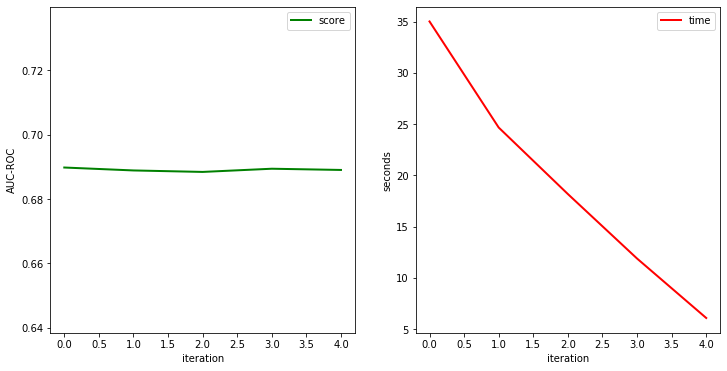

In [23]:
Visualisation(GB_score_cut, GB_time_cut)

Использование полной выборки или 20% от выборки почти не влияет на метрику качества. Зато при уменьшении выборки время обучения линейно убывает. На 20% исходной выборки AUC-ROC = 0.689 (разница с обучением на полной выборке на 4ом знаке после запятой), кросс-валидация на 30 деревьях длилась 6 секунд.

2. Логистическая регрессия

2.1 Оцените качество логистической регрессии с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C)
Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [24]:
grid = {'C': np.power(10.0, np.arange(-5, 6))}

model = LogisticRegression(penalty = 'l2', 
                           random_state = 241)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=241, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [25]:
LR_score = gs.cv_results_['mean_test_score']
LR_time = gs.cv_results_['mean_fit_time']
results(grid['C'], 'Значение параметра С: ', LR_score, LR_time)

Значение параметра С:  1e-05
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.47278943061828616
Значение параметра С:  0.0001
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.4789999485015869
Значение параметра С:  0.001
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.48158750534057615
Значение параметра С:  0.01
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.4596066474914551
Значение параметра С:  0.1
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.4552013874053955
Значение параметра С:  1.0
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.45358872413635254
Значение параметра С:  10.0
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.4991999626159668
Значение параметра С:  100.0
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.5265893459320068
Значение параметра С:  1000.0
Среднее качество:  0.5134556409261802
Среднее время обучения:  0.46158909797668457
З

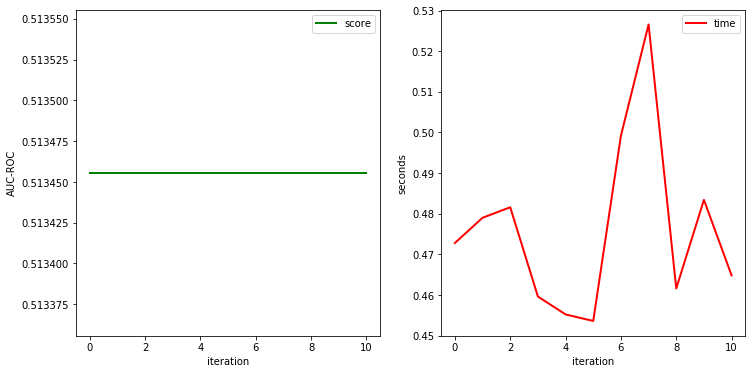

In [26]:
Visualisation(LR_score, LR_time, limit = 0.0001)

На исходных данных без масштабирования логистическая регрессия показывает результат намного хуже, чем градиентный бустинг. AUC-ROC = 0.513. При этом данный результат является константным для разных значений параметра С. Это происходит потому, что логистическая регрессия чувствительна к масштабу признаков. Плюс в данных присутствуют категориальные признаки.

In [27]:
# приведение признаков к одному масштабу
scaler = StandardScaler()
X_train_transform = scaler.fit_transform(X_train)

In [28]:
# подбор параметра регуляризации С
# из тестовых запусков выяснил, что оптимальный параметр для такой выборки лежит в интервале [0.001, 0.01]
grid = {'C': np.linspace(0.001, 0.01, 20)}

model = LogisticRegression(penalty = 'l2', 
                           random_state = 241)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train_transform, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=241, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.00147368, 0.00194737, 0.00242105, 0.00289474,
       0.00336842, 0.00384211, 0.00431579, 0.00478947, 0.00526316,
       0.00573684, 0.00621053, 0.00668421, 0.00715789, 0.00763158,
       0.00810526, 0.00857895, 0.00905263, 0.00952632, 0.01  

In [29]:
LR_score = gs.cv_results_['mean_test_score']
LR_time = gs.cv_results_['mean_fit_time']
results(grid['C'], 'Значение параметра С: ', LR_score, LR_time)

Значение параметра С:  0.001
Среднее качество:  0.7161793784078289
Среднее время обучения:  0.9038000583648682
Значение параметра С:  0.0014736842105263158
Среднее качество:  0.7162861719557814
Среднее время обучения:  0.9891921997070312
Значение параметра С:  0.0019473684210526317
Среднее качество:  0.7163313772464461
Среднее время обучения:  0.99779052734375
Значение параметра С:  0.0024210526315789475
Среднее качество:  0.7163488407930412
Среднее время обучения:  1.077191209793091
Значение параметра С:  0.0028947368421052633
Среднее качество:  0.7163548921371863
Среднее время обучения:  1.045391893386841
Значение параметра С:  0.003368421052631579
Среднее качество:  0.7163570329583762
Среднее время обучения:  1.1382004261016845
Значение параметра С:  0.003842105263157895
Среднее качество:  0.7163596261692414
Среднее время обучения:  1.1225927829742433
Значение параметра С:  0.00431578947368421
Среднее качество:  0.7163594365209797
Среднее время обучения:  1.1545825958251954
Значение

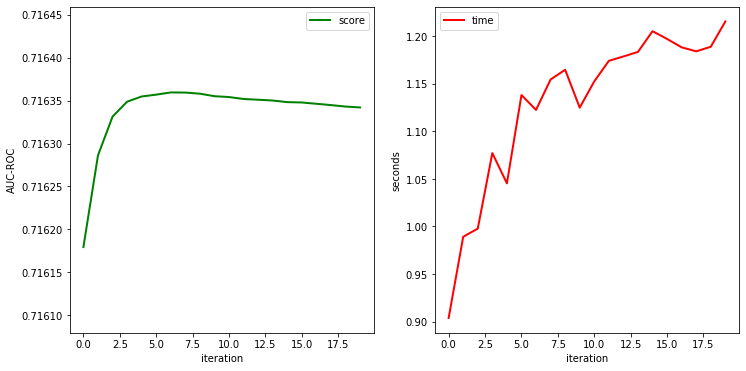

In [30]:
Visualisation(LR_score, LR_time, limit = 0.0001)

In [31]:
print(gs.best_score_)
print(gs.best_params_['C'])

0.7163596261692414
0.003842105263157895


Качество логистической регрессии над масштабированными признаками - 0.71635. Это выше, чем у градиентного бустинга из 30 деревьев на 0.027. И при этом алгоритм работает на порядок быстрее - время настройки на исходных данных в районе 1 секунды.

2.2 Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)?
Чем вы можете объяснить это изменение?

In [32]:
categorical_features = ['lobby_type', 
                        'r1_hero', 
                        'r2_hero', 
                        'r3_hero', 
                        'r4_hero', 
                        'r5_hero', 
                        'd1_hero', 
                        'd2_hero', 
                        'd3_hero', 
                        'd4_hero', 
                        'd5_hero']

In [33]:
# убираем категориальные признаки из выборки
X_train_drop = X_train.drop(categorical_features, axis = 1)

In [34]:
# приведение признаков к одному масштабу
scaler = StandardScaler()
X_train_drop_transform = scaler.fit_transform(X_train_drop)

In [35]:
# создаем дата-фрейм
X_train_drop_transform = pd.DataFrame(X_train_drop_transform, columns = X_train_drop.columns)

In [36]:
grid = {'C': np.linspace(0.001, 0.01, 20)}

model = LogisticRegression(penalty = 'l2', 
                           random_state = 241)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train_drop_transform, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=241, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.00147368, 0.00194737, 0.00242105, 0.00289474,
       0.00336842, 0.00384211, 0.00431579, 0.00478947, 0.00526316,
       0.00573684, 0.00621053, 0.00668421, 0.00715789, 0.00763158,
       0.00810526, 0.00857895, 0.00905263, 0.00952632, 0.01  

In [37]:
LR_score = gs.cv_results_['mean_test_score']
LR_time = gs.cv_results_['mean_fit_time']
results(grid['C'], 'Значение параметра С: ', LR_score, LR_time)

Значение параметра С:  0.001
Среднее качество:  0.7162348627989497
Среднее время обучения:  0.7867905616760253
Значение параметра С:  0.0014736842105263158
Среднее качество:  0.7163468715108854
Среднее время обучения:  0.907398271560669
Значение параметра С:  0.0019473684210526317
Среднее качество:  0.716388601996581
Среднее время обучения:  0.9666092872619629
Значение параметра С:  0.0024210526315789475
Среднее качество:  0.7164064573392415
Среднее время обучения:  0.9630002021789551
Значение параметра С:  0.0028947368421052633
Среднее качество:  0.7164130245348935
Среднее время обучения:  0.9389991283416748
Значение параметра С:  0.003368421052631579
Среднее качество:  0.7164153093030055
Среднее время обучения:  0.9852080821990967
Значение параметра С:  0.003842105263157895
Среднее качество:  0.7164137446878573
Среднее время обучения:  1.060800313949585
Значение параметра С:  0.00431578947368421
Среднее качество:  0.7164147028762413
Среднее время обучения:  1.0986101150512695
Значени

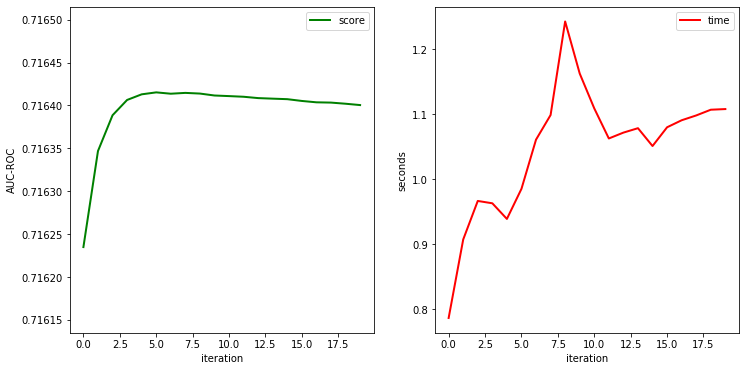

In [38]:
Visualisation(LR_score, LR_time, limit = 0.0001)

In [39]:
print(gs.best_score_)
print(gs.best_params_['C'])

0.7164153093030055
0.003368421052631579


Новое значение метрики качества - 0.71641. Совсем немного лучше, чем при обучении с категориальными признаками. Причина изменения - наличие категориальных признаков негативно сказывается на обучении линейных моделей.

2.3 Сколько различных идентификаторов героев существует в данной игре?

In [40]:
# словарь с идентификаторами героев
heroes = pd.read_csv('C:/Users/1/Data/Dota2/dictionaries/heroes.csv')

In [41]:
heroes.shape[0]

112

In [42]:
heroes[heroes['id'] == 24]

,id,localized_name,name


Исходя из словаря идентификаторов, в игре существует 112 различных героев. Идентификатор с номером 24 отсутствует.
Хотя фактически в игре использовалось меньше героев - 108. Идентификаторы героев 107, 108, 111, 113 в features.csv и features_test.csv отсутствуют

In [43]:
features[categorical_features].isin([107, 108, 111, 113])

,lobby_type,r1_hero,r2_hero,r3_hero,r4_hero,r5_hero,d1_hero,d2_hero,d3_hero,d4_hero,d5_hero
match_id,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
114402,False,False,False,False,False,False,False,False,False,False,False
114403,False,False,False,False,False,False,False,False,False,False,False
114404,False,False,False,False,False,False,False,False,False,False,False


2.4 Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? 
Чем вы можете это объяснить?

In [44]:
# создаем мешок слов по героям
X_pick = np.zeros((features.shape[0], heroes.shape[0] + 1)) # учтем, что идентификатор 24 пропущен и номер последнего id = 113

for i, match_id in enumerate(features.index):
    for p in range(5):
        X_pick[i, features.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick[i, features.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1

In [45]:
# создаем список столбцов для дата-фрейма с героями
hero_columns = []
for i in range(X_pick.shape[1]):
    if i == 23: # этот идентификатор отсутствует
        column = 'None'
    else:
        column = list(heroes.loc[heroes['id'] == (i + 1), 'localized_name'])[0]
    hero_columns.append(column)

In [46]:
X_pick = pd.DataFrame(X_pick, columns = hero_columns)
X_pick.head()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,Shadow Fiend,Phantom Lancer,Puck,Pudge,Razor,Sand King,Storm Spirit,Sven,Tiny,Vengeful Spirit,Windranger,Zeus,Kunkka,None,Lina,Lion,Shadow Shaman,Slardar,Tidehunter,Witch Doctor,Lich,Riki,Enigma,Tinker,Sniper,Necrophos,Warlock,Beastmaster,Queen of Pain,Venomancer,Faceless Void,Skeleton King,Death Prophet,Phantom Assassin,Pugna,Templar Assassin,Viper,Luna,Dragon Knight,Dazzle,Clockwerk,Leshrac,Nature's Prophet,Lifestealer,Dark Seer,Clinkz,Omniknight,Enchantress,Huskar,Night Stalker,Broodmother,Bounty Hunter,Weaver,Jakiro,Batrider,Chen,Spectre,Ancient Apparition,Doom,Ursa,Spirit Breaker,Gyrocopter,Alchemist,Invoker,Silencer,Outworld Devourer,Lycanthrope,Brewmaster,Shadow Demon,Lone Druid,Chaos Knight,Meepo,Treant Protector,Ogre Magi,Undying,Rubick,Disruptor,Nyx Assassin,Naga Siren,Keeper of the Light,Wisp,Visage,Slark,Medusa,Troll Warlord,Centaur Warrunner,Magnus,Timbersaw,Bristleback,Tusk,Skywrath Mage,Abaddon,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# удалим героев, которые вообще не использовались в играх
unused_heroes = ['None', 'Abyssal Underlord', 'Earth Spirit', 'Oracle', 'Arc Warden']
X_pick.drop(unused_heroes, axis = 1, inplace = True)

In [48]:
# соединяем вместе два дата-фрейма
X_train_pick = pd.merge(X_train_drop_transform, X_pick, on = X_train_drop.index)
X_train_pick.drop('key_0', axis = 1, inplace = True)

In [49]:
X_train_pick.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_level,d4_xp,d4_gold,...,Dazzle,Clockwerk,Leshrac,Nature's Prophet,Lifestealer,Dark Seer,Clinkz,Omniknight,Enchantress,Huskar,Night Stalker,Broodmother,Bounty Hunter,Weaver,Jakiro,Batrider,Chen,Spectre,Ancient Apparition,Doom,Ursa,Spirit Breaker,Gyrocopter,Alchemist,Invoker,Silencer,Outworld Devourer,Lycanthrope,Brewmaster,Shadow Demon,Lone Druid,Chaos Knight,Meepo,Treant Protector,Ogre Magi,Undying,Rubick,Disruptor,Nyx Assassin,Naga Siren,Keeper of the Light,Wisp,Visage,Slark,Medusa,Troll Warlord,Centaur Warrunner,Magnus,Timbersaw,Bristleback,Tusk,Skywrath Mage,Abaddon,Elder Titan,Legion Commander,Techies,Ember Spirit,Terrorblade,Phoenix,Winter Wyvern
0,-2.544364,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,1.50723,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,1.052453,1.115474,-0.417344,-0.322641,-0.337650,0.082842,-0.548801,-0.564562,-0.928921,0.561134,-0.208412,-0.272358,0.173184,-0.540261,-0.569909,-1.774695,1.488903,1.558823,0.961587,1.416964,-0.538253,-0.571065,-0.947053,-0.311205,-0.785580,-1.312874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-2.540452,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.59158,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,-0.573665,-1.352836,1.392776,1.286498,0.507465,0.526938,-0.548801,-0.564562,-0.119890,-0.357152,-1.015865,-1.205140,-1.064184,-0.540261,1.072422,-1.362973,-0.347705,-0.859912,0.548265,-0.942193,2.506742,-0.571065,1.517711,-1.232681,-1.337375,-1.127777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.539231,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-0.32407,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-0.277630,0.427498,1.202532,1.900308,-0.524078,-0.573665,0.292704,1.392776,1.901968,1.910183,0.860010,0.925434,1.076171,0.689141,-0.357152,-0.319096,-0.332322,0.960600,-0.540261,1.072422,0.695638,-0.347705,-0.796356,-1.073911,-0.829853,-0.538253,-0.571065,-0.125465,0.610270,0.268676,-0.940451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.532622,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,1.50723,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,-0.573665,-0.941451,1.392776,1.140213,0.050057,0.637962,-0.5

In [50]:
# на таких данных интервал для поиска оптимального параметра С сдвинулся
grid = {'C': np.linspace(0.04, 0.06, 20)}

# max_iter = 1000 (по-умолчанию 100). В противном случае возникает предупреждение о несходимости оптимизации
model = LogisticRegression(penalty = 'l2', 
                           random_state = 241, 
                           max_iter = 1000)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train_pick, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=241, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.04      , 0.04105263, 0.04210526, 0.04315789, 0.04421053,
       0.04526316, 0.04631579, 0.04736842, 0.04842105, 0.04947368,
       0.05052632, 0.05157895, 0.05263158, 0.05368421, 0.05473684,
       0.05578947, 0.05684211, 0.05789474, 0.05894737, 0.06 

In [51]:
LR_score = gs.cv_results_['mean_test_score']
LR_time = gs.cv_results_['mean_fit_time']
results(grid['C'], 'Значение параметра С: ', LR_score, LR_time)

Значение параметра С:  0.04
Среднее качество:  0.7519422284832975
Среднее время обучения:  4.9059998989105225
Значение параметра С:  0.04105263157894737
Среднее качество:  0.7519425993882345
Среднее время обучения:  4.97618932723999
Значение параметра С:  0.042105263157894736
Среднее качество:  0.7519440172054004
Среднее время обучения:  4.654608917236328
Значение параметра С:  0.0431578947368421
Среднее качество:  0.7519430956033814
Среднее время обучения:  4.7312102794647215
Значение параметра С:  0.04421052631578947
Среднее качество:  0.7519436594378335
Среднее время обучения:  4.591798400878906
Значение параметра С:  0.04526315789473684
Среднее качество:  0.7519433119967278
Среднее время обучения:  4.747398424148559
Значение параметра С:  0.04631578947368421
Среднее качество:  0.7519430453006685
Среднее время обучения:  4.630189418792725
Значение параметра С:  0.04736842105263158
Среднее качество:  0.7519430891435986
Среднее время обучения:  4.721821451187134
Значение параметра С: 

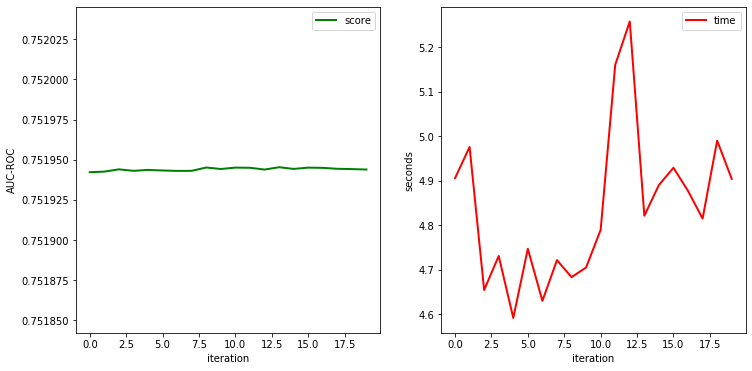

In [52]:
Visualisation(LR_score, LR_time, limit = 0.0001)

In [53]:
print(gs.best_score_)
print(gs.best_params_['C'])
best_C = gs.best_params_['C']

0.7519453362439685
0.053684210526315786


Качество после добавления мешка слов по героям - 0.7519. Это наилучший достигнутый результат среди испробованных подходов. Такой рост метрики качества можно объяснить тем, что важные категориальные признаки включены в обучающую выборку в виде мешка слов. Этот способ представления признаков гораздо больше подходит для работы с линейными моделями.
Однако возросло время настройки алгоритма. Теперь оно варьируется около 5 секунд. Тем не менее, это всё ещё лучше, чем у градиентного бустинга.

2.5 Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации)
Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [54]:
features_test = pd.read_csv('C:/Users/1/Data/Dota2/features_test.csv', index_col='match_id')

In [55]:
# обучаем модель
model = LogisticRegression(penalty = 'l2', 
                           random_state = 241, 
                           C = best_C, 
                           max_iter = 1000)
model.fit(X_train_pick, Y_train)

LogisticRegression(C=0.053684210526315786, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=241, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
X_test = features_test.iloc[:, :]
X_test = X_test.drop(categorical_features, axis = 1)
columns = X_test.columns
X_test.fillna(0, inplace = True)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = columns)

In [57]:
# создаем мешок слов по героям для тестовой выборки
X_pick = np.zeros((features_test.shape[0], heroes.shape[0] + 1))
for i, match_id in enumerate(features_test.index):
    for p in range(5):
        X_pick[i, features_test.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick[i, features_test.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1

In [58]:
X_pick = pd.DataFrame(X_pick, columns = hero_columns)

# удалим героев, которые вообще не использовались в играх
X_pick.drop(unused_heroes, axis = 1, inplace = True)

In [59]:
X_test_pick = pd.merge(X_test, X_pick, on = X_test.index)
X_test_pick.drop('key_0', axis = 1, inplace = True)

In [60]:
radiant_win = model.predict_proba(X_test_pick)[:, 1]

In [61]:
print(radiant_win.min())
print(radiant_win.max())

0.008407881040036909
0.99631935044547


Минимальное значение прогноза на тестовой выборке: 0.008
Максимальное значение прогноза на тестовой выборке: 0.996

In [62]:
match_id = pd.read_csv('C:/Users/1/Data/Dota2/features_test.csv')['match_id']
submission = pd.DataFrame({'match_id': match_id, 'radiant_win': radiant_win})
submission

,match_id,radiant_win
0,6,0.822845
1,7,0.751604
2,10,0.188826
3,13,0.862842
4,16,0.240346
...,...,...
17172,114369,0.718886
17173,114377,0.631090
17174,114378,0.233867
17175,114393,0.622002
